# Part 9 of Quick Start: Automation & Macros

This page is primarily based on the following page at the Circos documentation site:

- [9. AUTOMATION & MACROS](http://circos.ca/documentation/tutorials/quick_start/automation_and_macros/)

That page is found as part number 9 of the nine part [the 'QUICK START' section](http://circos.ca/documentation/tutorials/quick_start/) of [the larger set of Circos tutorials](http://circos.ca/documentation/tutorials/).

Go back to Part 8 by clicking [here &#8592;](Quick_Start_Part8.ipynb).

----



## Automation & Macros

This is the ninth and final step in the series of nine Quick Guide tutorials. 

This is an advanced topic that Martin illustrates.

The following is adapted from the documentation page:

### REFERENCING CONFIGURATION PARAMETERS

Within a configuration file, you can refer to a configuration parameter value using `conf()`.

If the parameter you wish to refer to is in the same block, then use `conf(param)`.

```ini
x = 1
y = conf(x)
```

If the parameter is in a specific block hierarchy elsewhere, list the blocks first.

```ini
<b1>
 <b2>
  x = 1
 </b2>
</b1>

y = conf(b1,b2,x)
```

Note that you cannot currently access a block hierarchy that includes multiple blocks with the same n ame.

If the parameter is somewhere up the hierarchy from where it is called, use `conf(.,param)`

```ini
<b1>
 x = 1
 <b2>
  <b3>
   y = conf(.,x)
  </b3>
 </b2>
</b1>
```

### AUTOMATING TRACKS

Together with track counters, the `conf()` function can be used to create different tracks from the same configuration file. This is extremely useful when you need to show several tracks using data whose source and/or format can be parametrized.

For example, you can create the four heatmaps in this example from the same block. The heatmap blocks are

```ini
type  = heatmap
file  = data/5/segdup.hs1234.heatmap.txt
r1    = 0.89r
r0    = 0.88r
color = hs1_a5,hs1_a4,hs1_a3,hs1_a2,hs1_a1,hs1
scale_log_base = 0.25

<rules>
<<include rule.exclude.hs1.conf>>
</rules>
```

They have the same `type`, `file`, and `scale_log_base` parameters and `<rules>` block. The `r0` and `r1` parameters change by 0.01 for successive blocks and the `color` parameter can be parametrized by the index of the chromosome (e.g. `hsi` for `i = 1..4`).

Instead of including the block above four times, once for each heatmap, with hard-coded `r0`, `r1` and `color` values, we can generate these parameter values automatically using block counters, which are internal variables that provide a 0-indexed identifier for each block in the configuration file.

This block below will be parsed the same as the one above. When it is included several times, the value of `counter(heatmap)` will be incremented each time, allowing for dynamically changing `r0`, `r1`, and `color` parameters.

```ini
# heatmap.conf

type           = heatmap
file           = data/5/segdup.hs1234.heatmap.txt

# The 'c' parameter (arbitrarily named) is referenced
# within heatmap.conf as conf(.,c). conf(x) retrieves
# the value of parameter 'x' in the current block and
# conf(.,x) looks up the configuration tree until
# it finds x.

c = eval(sprintf("hs%d",counter(heatmap)+1))

# track_r0(counter,start,width,padding) 
# track_r1(counter,start,width,padding) 
# are helper functions that return the start/end radius of a track
# formatted as float+"r", e.g. 0.925r
# 
# r0 = start + counter * (width + padding) 
# r1 = start + counter * (width + padding) + width
#
# The calls to conf(.,x) reference the  block's h0, hw and hp
# parameters. The counter(heatmap) is an 0-start automatically incremented
# index, which is incremented by 1 for each type=heatmap plot.
#
r1    = eval(track_r1(counter(heatmap),conf(.,h0),conf(.,hw),conf(.,hp)))
r0    = eval(track_r0(counter(heatmap),conf(.,h0),conf(.,hw),conf(.,hp)))

# conf(.,c) references the  block's 'c' parameter
color          = conf(.,c)_a5,conf(.,c)_a4,conf(.,c)_a3,conf(.,c)_a2,conf(.,c)_a1,conf(.,c)
scale_log_base = 0.25

<rules>
<<include rule.exclude.hs1.conf>>
<rule>
# hides any data point whose 'id' parameter is not
# the same as the  block 'c' parameter
condition = var(id) ne "conf(.,c)"
show      = no
</rule>
</rules>
```

Here's how to include the block multiple times.

```ini
<plot>
<<include heatmap.conf>>
</plot>

<plot>
<<include heatmap.conf>>
</plot>

<plot>
<<include heatmap.conf>>
</plot>

<plot>
<<include heatmap.conf>>
</plot>
```

You can include the block directives in the `heatmap.conf` file so that the main configuration file is even simpler.

```ini
# circos.conf
<<include heatmap.conf>>
<<include heatmap.conf>>
<<include heatmap.conf>>
<<include heatmap.conf>>
# heatmap.conf
<plot>
...
</plot>
```

### conf VS var

The `conf(x)` function retrieves the value of a configuration parameter at the time that the configuration file is compiled. This happens in the initial part of the code before any data is processed.

You can see the effect of the `conf(x)` function by running

```
> circos -cdump plots
...
{
 c => 'hs2',
 color => 'hs2_a5,hs2_a4,hs2_a3,hs2_a2,hs2_a1,hs2',
 file => 'data/5/segdup.hs1234.heatmap.txt',
 r0 => '0.890000r',
 r1 => '0.900000r',
 rules => {
            rule => [
                      {
                        condition => 'on(hs1)',
                        show => 0
                      },
                      {
                        condition => 'var(id) ne "hs2"',
                        show => 0
                      }
                    ]
          },
 scale_log_base => '0.25',
 type => 'heatmap'
}
...
```

After parsing the configuration file, the value of the `c`, `r0`, `r1`, and `color` parameters has already been determined. These are now constant for the rest of the time Circos is running.

On the other hand, the `var(x)` function retrieves the value of the `x` parameter for a data point and is evaluated **dynamically** for each data point.

The condition of the second rule has already been parsed and the call to `conf(.,c)` has returned, for the case of this block, `hs2`. As each data point is tested, the value of `var(id)` will be replaced by the point's `id` parameter and the condition will be tested with this value.



----

### Generating the plot produced by this example code

The following two cells will generate the plot. The first cell adjusts the current working directory.

In [1]:
%cd ../circos-tutorials-0.67/tutorials/1/9/

/home/jovyan/circos-tutorials-0.67/tutorials/1/9


In [2]:
%%bash
../../../../circos-0.69-6/bin/circos -conf circos.conf

debuggroup summary 0.27s welcome to circos v0.69-6 31 July 2017 on Perl 5.022000
debuggroup summary 0.27s current working directory /home/jovyan/circos-tutorials-0.67/tutorials/1/9
debuggroup summary 0.27s command ../../../../circos-0.69-6/bin/circos -conf circos.conf
debuggroup summary 0.27s loading configuration from file circos.conf
debuggroup summary 0.27s found conf file circos.conf
debuggroup summary 0.47s debug will appear for these features: output,summary
debuggroup summary 0.47s bitmap output image ./circos.png
debuggroup summary 0.47s SVG output image ./circos.svg
debuggroup summary 0.47s parsing karyotype and organizing ideograms
debuggroup summary 0.56s karyotype has 24 chromosomes of total size 3,095,677,436
debuggroup summary 0.57s applying global and local scaling
debuggroup summary 0.59s allocating image, colors and brushes
debuggroup summary 2.41s drawing 4 ideograms of total size 881,626,704
debuggroup summary 2.41s drawing highlights and ideograms
debuggroup summary

Use of uninitialized value in subroutine entry at /home/jovyan/circos-0.69-6/bin/../lib/Circos/Configuration.pm line 781.
Use of uninitialized value in subroutine entry at /home/jovyan/circos-0.69-6/bin/../lib/Circos/Configuration.pm line 781.
Use of uninitialized value in subroutine entry at /home/jovyan/circos-0.69-6/bin/../lib/Circos/Configuration.pm line 781, <F> line 23512.
Use of uninitialized value in subroutine entry at /home/jovyan/circos-0.69-6/bin/../lib/Circos/Configuration.pm line 781.
Use of uninitialized value in subroutine entry at /home/jovyan/circos-0.69-6/bin/../lib/Circos/Configuration.pm line 781.
Use of uninitialized value in subroutine entry at /home/jovyan/circos-0.69-6/bin/../lib/Circos/Configuration.pm line 781.
Use of uninitialized value in subroutine entry at /home/jovyan/circos-0.69-6/bin/../lib/Circos/Configuration.pm line 781.
Use of uninitialized value in subroutine entry at /home/jovyan/circos-0.69-6/bin/../lib/Circos/Configuration.pm line 781.
Use of u

View the plot in this page using the following cell.

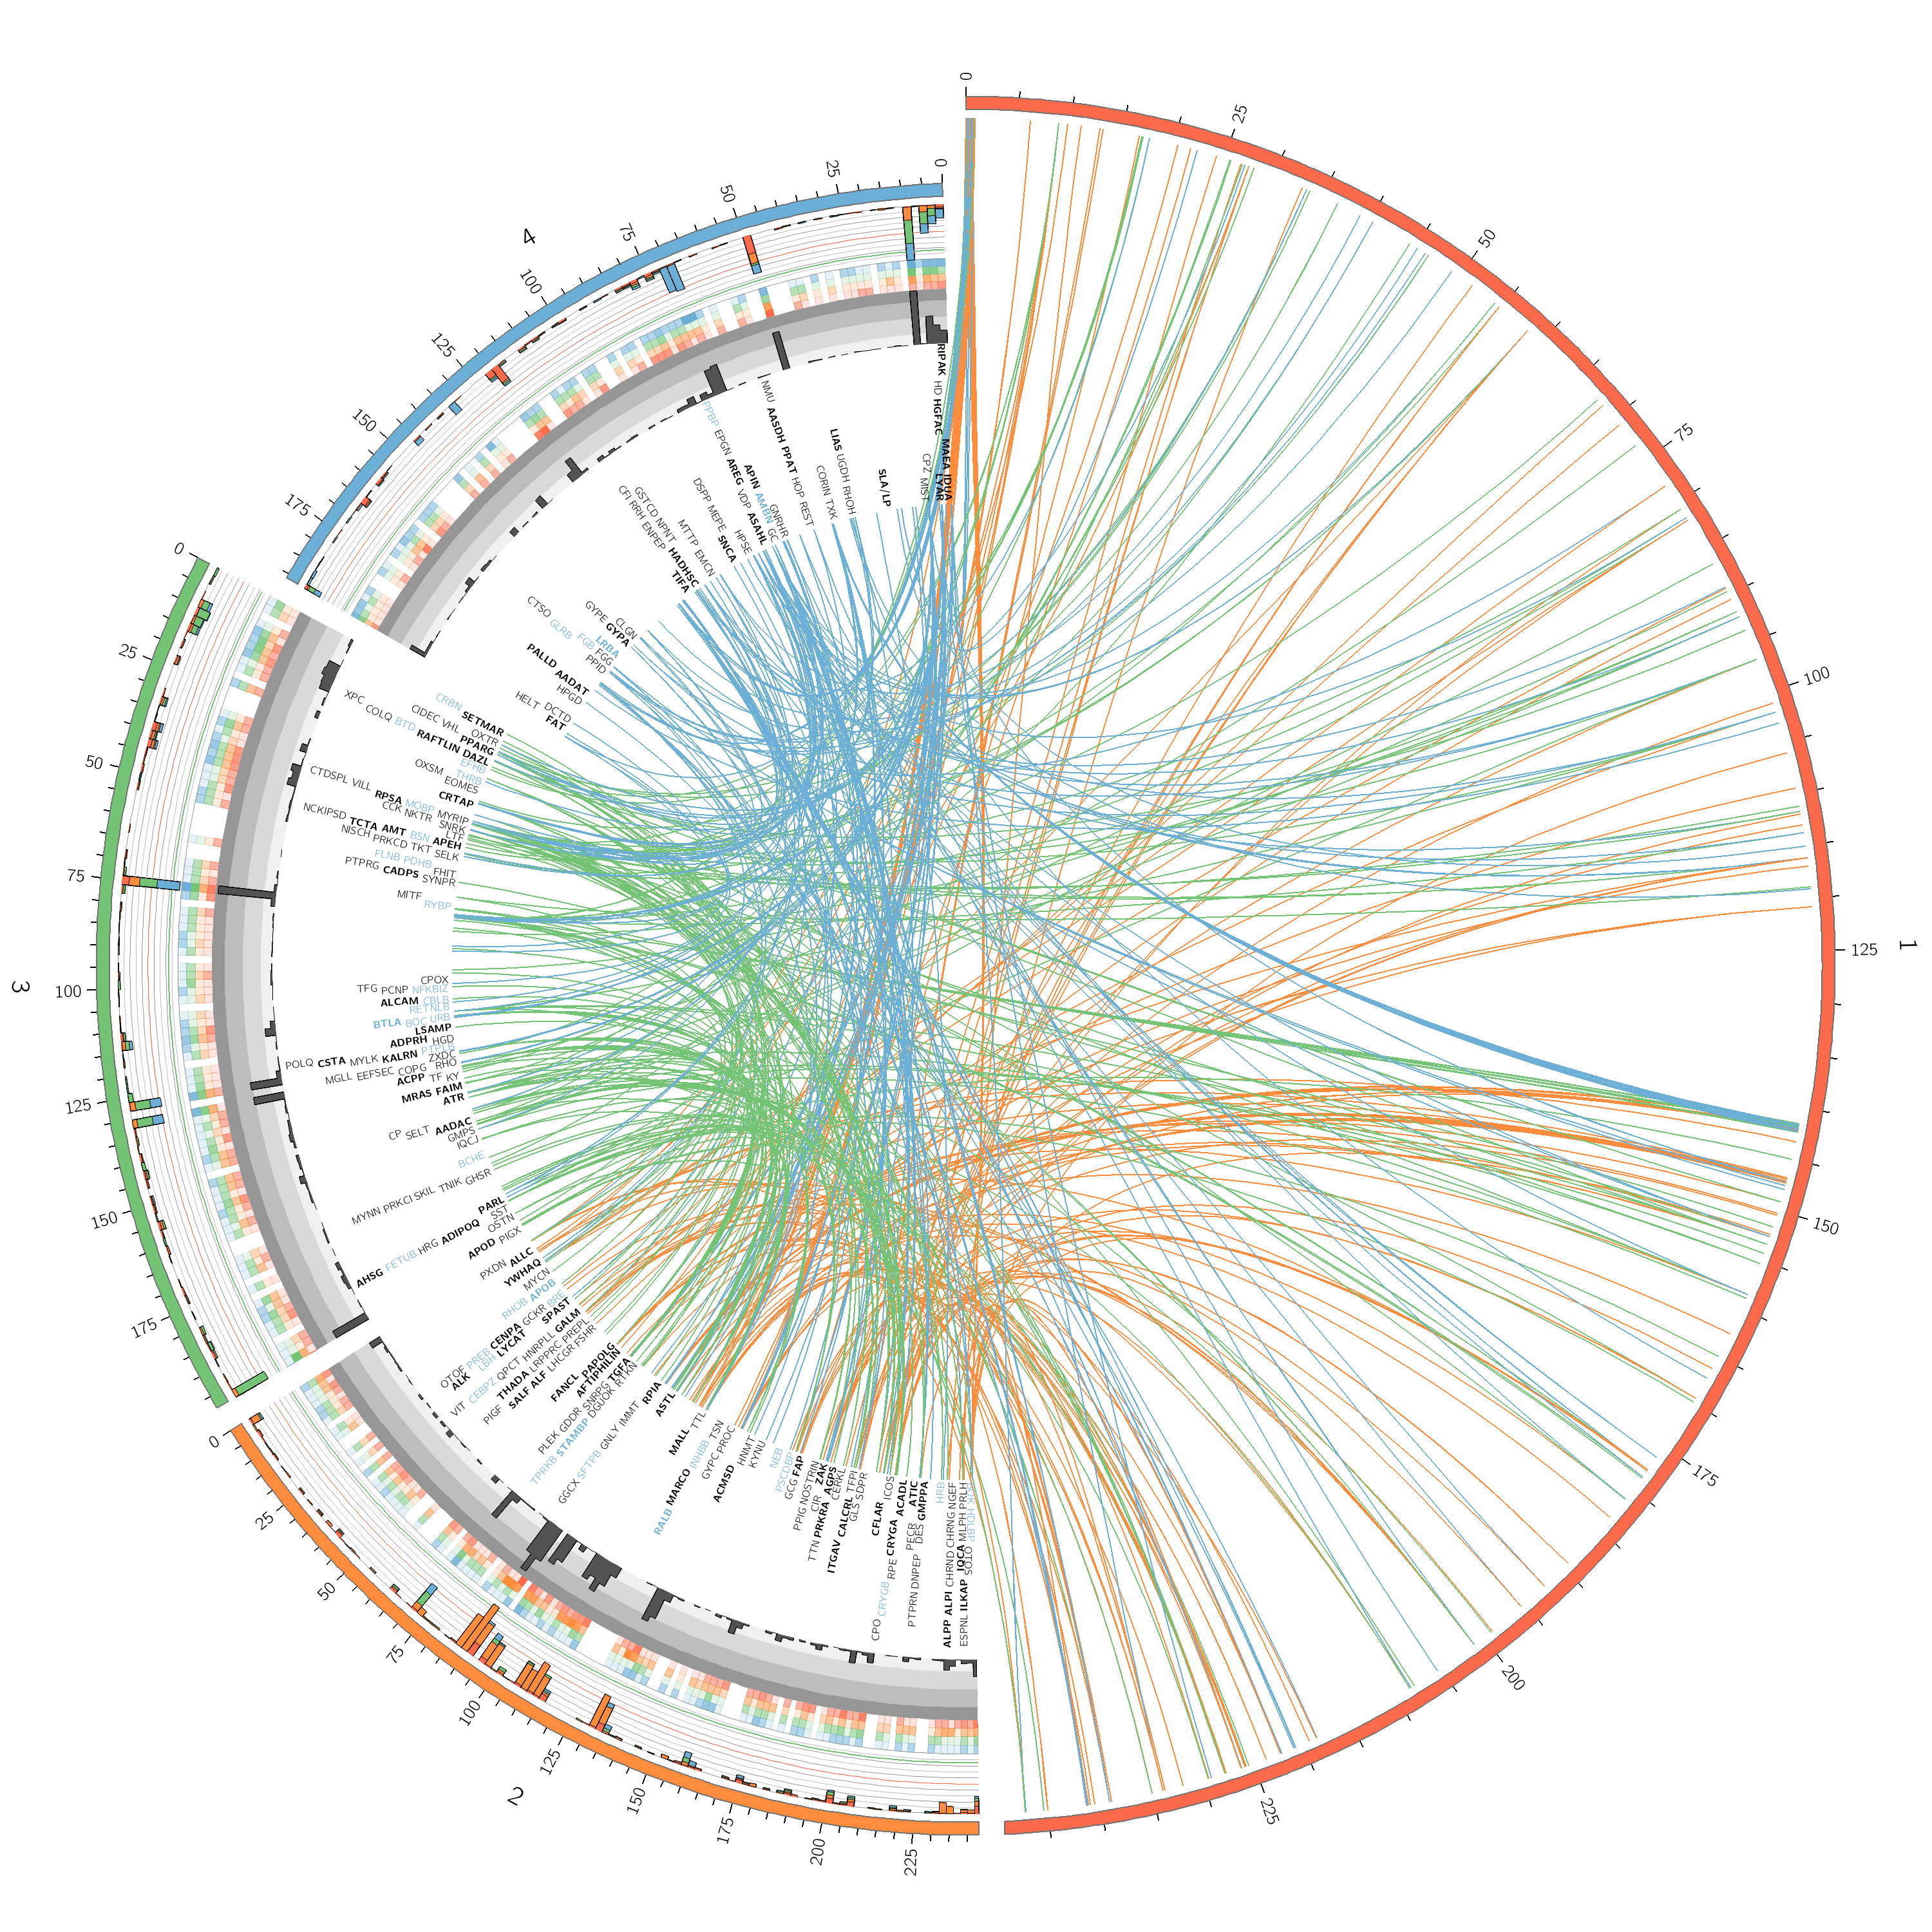

In [3]:
from IPython.display import Image
Image("circos.png")

----

Continue on to the next part of the Tutorials series by clicking [here &#10145;](Drawing_Ideograms_Part1.ipynb)</font>. 

----